In [3]:
import pytorch_lightning as pl
from matplotlib import pyplot as plt
import seaborn as sns
from cca_zoo.deepmodels import (
    DCCA,
    #DCCA_NOI,
    DCCA_SDL,
    #BarlowTwins,
    get_dataloaders,
    
)
from cca_zoo.deepmodels.utils import architectures, objectives
from cca_zoo.plotting import pairplot_label
from cca_zoo.data import CCA_Dataset
from cca_zoo.models import CCA
import torch.optim as optim
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
import os
from scipy.spatial import distance
from scipy.stats import pearsonr
from scipy.stats import fisher_exact
from scipy.stats.contingency import crosstab
from scipy.stats import hypergeom
import random
import pandas as pd
import numpy as np
import pickle
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from openeye import oechem



os.chdir('../raw_data')


#### Functions to load and or write to pickle files

In [4]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

In [5]:
# load df with all info
path = './df_classes_max3_embeddings.pickle'
df_all = Files(path).load_pickle()#[:1000] #just a subset for scripting
df_all.shape

(41447, 8)

In [6]:
from rdkit import Chem, Geometry
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from rdkit.Chem import PandasTools


In [7]:
smiles = [x for x in df_all['smiles']]

In [8]:
mols = [Chem.MolFromSmiles(x) for x in smiles]

[17:41:30] WARNING: not removing hydrogen atom without neighbors


In [13]:
len(mols)

41447

In [155]:
#mcs1 = rdFMCS.FindMCS(mols)

mol1 = mols[2]
mol2 = mols[20]
two_mols = [mol1, mol2]
tow_msc1 = rdFMCS.FindMCS(two_mols,
                    
                    #minNumAtoms=2,
                    completeRingsOnly=True,    
                    ringMatchesRingOnly=True,
                    threshold=0.1)

In [156]:
tow_msc1.numAtoms/mol1.GetNumAtoms()

0.047619047619047616

In [138]:
int(mol1.GetNumAtoms()*0.5)

21

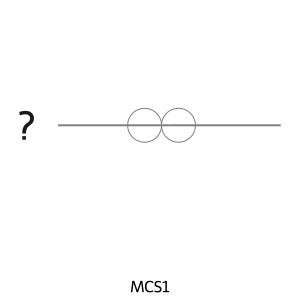

In [143]:
# Draw substructure from Smarts
m1 = Chem.MolFromSmarts(tow_msc1.smartsString)
Draw.MolToImage(m1, legend="MCS1")

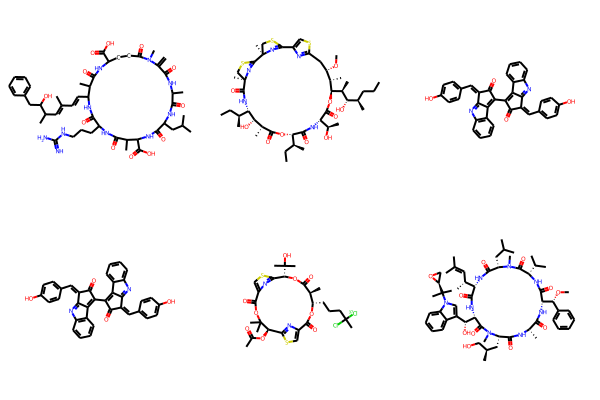

In [95]:
Draw.MolsToGridImage(mols[0:6])

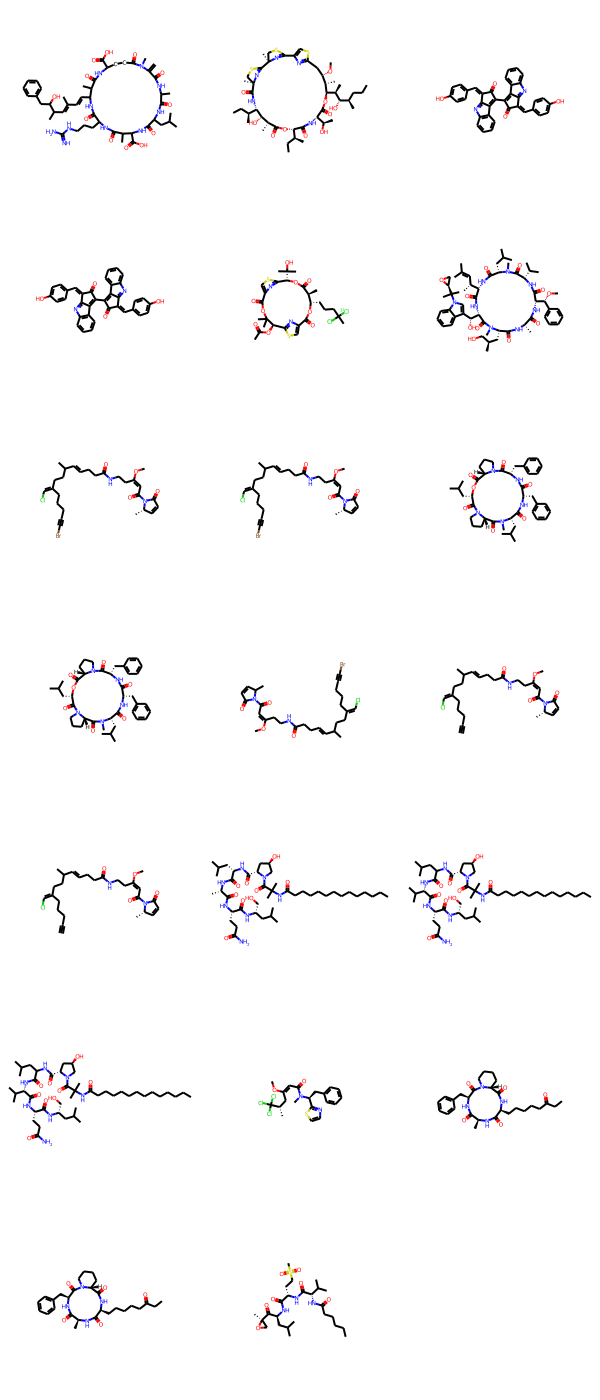

In [70]:
Draw.MolsToGridImage(mols[:])

In [ ]:
# class DataFiltering:
#     def __init__(self, spectra):
#         self.spectra = spectra
        
#         # thresholds for selecting higher quality spectra
#         self.intensity_thres = 0.01
#         self.n_peaks_required = 10
#         self.gnps_spec_quality_measure = 3
    
#     def count_higher_peaks(self, index=0,threshold = 0.1):
#         spectrum = self.spectra[index]
#         return np.sum(spectrum.peaks.intensities/\
#                       spectrum.peaks.intensities.max() >= threshold)

    
#     def get_ids_for_unique_inchikeys(self): #: List[SpectrumType]
#         """Return indices for best chosen spectra for each unique inchikey
#         Parameters
#         ----------
#         spectrums:
#             Input spectra
#         """
#         # collect all inchikeys (first 14 characters)
#         inchikey_collection = OrderedDict()
#         for i, spec in enumerate(self.spectra):
#             inchikey = spec.get("inchikey")
#             if inchikey:
                
                    
#                 if inchikey[:14] in inchikey_collection:
#                     inchikey_collection[inchikey[:14]] += [i]
                   
                    
#                 else:
#                     inchikey_collection[inchikey[:14]] = [i]
            

        
#         ID_picks = []

#         inchikey14_unique = [x for x in inchikey_collection.keys()]

#         # Loop through all unique inchiques (14 first characters)
#         for inchikey14 in inchikey14_unique:
#             specIDs = np.array(inchikey_collection[inchikey14])
            
#             if specIDs.size == 1:
#                 ID_picks.append(specIDs[0])
#             else:
#                 # 1 select spec with sufficient peaks (e.g. 10 with intensity 0.01)
#                 num_peaks = np.array([self.count_higher_peaks(
#                     index=specID, threshold=self.intensity_thres) for
#                                       specID in specIDs])
#                 sufficient_peaks = np.where(num_peaks >= self.n_peaks_required)[0]
#                 if sufficient_peaks.size == 0:
#                     sufficient_peaks = np.where(num_peaks == max(num_peaks))[0]
#                 step1IDs = specIDs[sufficient_peaks]

#                 # 2 select best spectrum qualities
#                 # (according to gnps measure). 1 > 2 > 3
#                 qualities = np.array(
#                     [int(self.spectra[specID].get("library_class",\
#                                                   self.gnps_spec_quality_measure))
#                      for specID in step1IDs])  # default is 3; worst quality
#                 step2IDs = step1IDs[np.where(qualities == min(qualities))[0]]

#                 # 3 Select the ones with most peaks > threshold
#                 num_peaks = np.array([self.count_higher_peaks(
#                     index=specID, threshold=self.intensity_thres) for specID in step2IDs])
                
#                 pick = np.argmax(num_peaks)
#                 ID_picks.append(step2IDs[pick])
#         ID_picks.sort()  # ensure order

#         return ID_picks
    
#     # pick unique spectra using the unique inchikeys
    
#     def unique_spectra(self):
#         uniq_inchikeys = self.get_ids_for_unique_inchikeys()
#         uniq_spec_data = [self.spectra[i] for i in uniq_inchikeys]
        
#         return uniq_spec_data
        
    